<a href="https://colab.research.google.com/github/alexispuetate-paspuel/-rms_comparacion_senales.py/blob/main/proyecto_3_computacion_numerica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Librerías y configuración**
En esta parte instalo y cargo las librerías necesarias para el análisis.
pandas y numpy las uso para manejar y transformar los datos,
matplotlib y seaborn para crear las gráficas,
y scikit-learn para construir y evaluar el modelo de predicción.
También importo algunas funciones de Google Colab para cargar archivos.
Finalmente, configuro el estilo de las gráficas con fondo blanco y tamaño más grande para que sean más legibles.

In [138]:
!pip install seaborn scikit-learn matplotlib pandas requests --quiet

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests, io, zipfile, json
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

**Función para generar datos simulados**:
En esta parte creo una función que genera datos simulados para un país.
Lo que hace es crear fechas entre enero y diciembre de 2024 y, a partir de ahí, genera valores aleatorios que representan el precio spot, los niveles de embalses, los combustibles y las precipitaciones.
De esta forma puedo trabajar con datos realistas y consistentes para hacer las pruebas y los análisis del modelo.

In [139]:
def generar_datos_pais(nombre, precio_base, start="2024-01-01", end="2024-12-31"):
    np.random.seed(abs(hash(nombre)) % 2**32)
    fechas = pd.date_range(start=start, end=end, freq="D")
    n = len(fechas)
    precio = precio_base + np.random.normal(0, 10, n).cumsum()
    embalses = np.clip(80 + np.random.normal(0, 5, n).cumsum()/10, 30, 100)
    combustibles = 70 + np.random.normal(0, 3, n).cumsum()/5
    precipitaciones = np.abs(np.sin(np.linspace(0, 6, n))*100 + np.random.normal(0, 12, n))
    return pd.DataFrame({
        "Fecha": fechas,
        "Valor": precio,
        "Embalses": embalses,
        "Combustibles": combustibles,
        "Precipitaciones": precipitaciones,
        "País": nombre
    })

**Carga y limpieza de datos**
En esta parte el programa me da tres opciones para obtener los datos: subir un archivo propio en formato CSV, descargarlos directamente desde la API de SIMEM, o generar datos simulados.
Dependiendo de la opción elegida, el código carga los datos, limpia los nombres de las columnas y los estandariza para que siempre tengan las variables principales como Fecha, Valor, Embalses, Combustibles y Precipitaciones.

In [140]:
print("1 - Subir CSV propio")
print("2 - Descargar desde API SIMEM")
print("3 - Usar datos simulados")
modo = input("Selecciona modo (1,2 o 3): ").strip()
df_col, pais_nombre = None, "Desconocido"

if modo == "1":
    uploaded = files.upload()
    nombre = list(uploaded.keys())[0]
    df_col = pd.read_csv(io.BytesIO(uploaded[nombre]), engine="python")
    pais_nombre = nombre.split('.')[0].capitalize()
elif modo == "2":
    pais_nombre = "Colombia"
    dataset_id = "96D56E82-11CB-4D87-92B6-EC7A621D9D9C"
    start_date = input("Inicio (YYYY-MM-DD): ")
    end_date = input("Fin (YYYY-MM-DD): ")
    url = f"https://www.simem.co/backend-files/api/datos-publicos?datasetId={dataset_id}&startDate={start_date}&endDate={end_date}"
    resp = requests.post(url, json=[], timeout=30)
    df_col = pd.DataFrame(resp.json())
else:
    pais_nombre = "Colombia"
    df_col = generar_datos_pais(pais_nombre, 300)

def normalize_cols(df):
    df.columns = [c.strip().replace("\ufeff","") for c in df.columns]
    return df

df_col = normalize_cols(df_col)

if "anio_mes" in df_col.columns and "Fecha" not in df_col.columns:
    df_col.rename(columns={"anio_mes":"Fecha"}, inplace=True)
if "precio_promedio_cop_kwh" in df_col.columns and "Valor" not in df_col.columns:
    df_col.rename(columns={"precio_promedio_cop_kwh":"Valor"}, inplace=True)


if "Fecha" not in df_col.columns and "fecha" in df_col.columns:
    df_col.rename(columns={"fecha":"Fecha"}, inplace=True)
df_col["Fecha"] = pd.to_datetime(df_col["Fecha"], errors="coerce")
df_col = df_col.dropna(subset=["Fecha"]).sort_values("Fecha").reset_index(drop=True)

if "Valor" not in df_col.columns:
    for c in ["PPBO","Precio","Precio_spot","Precio Spot"]:
        if c in df_col.columns:
            df_col.rename(columns={c:"Valor"}, inplace=True)
            break
for c in ["Embalses","Combustibles","Precipitaciones"]:
    if c not in df_col.columns:
        df_col[c] = np.nan

display(df_col.head())

1 - Subir CSV propio
2 - Descargar desde API SIMEM
3 - Usar datos simulados
Selecciona modo (1,2 o 3): 1


Saving Colombia - copia.csv to Colombia - copia.csv


,CodigoVariable,Fecha,CodigoDuracion,UnidadMedida,Version,Valor,Embalses,Combustibles,Precipitaciones
0,PPBO,2024-01-01,P1D,COP/kWh,TXF,220.86,NaN,NaN,NaN
1,PPBOGReal,2024-01-01,P1D,COP/kWh,TXF,225.62,NaN,NaN,NaN
2,PPBO,2024-01-01,P1D,COP/kWh,TX4,221.09,NaN,NaN,NaN
3,PPBOGReal,2024-01-01,P1D,COP/kWh,TX4,225.87,NaN,NaN,NaN
4,PPBO,2024-01-01,P1D,COP/kWh,TX2,219.08,NaN,NaN,NaN


**Suavización e Interpolación del Precio Spot y su Volatilidad**

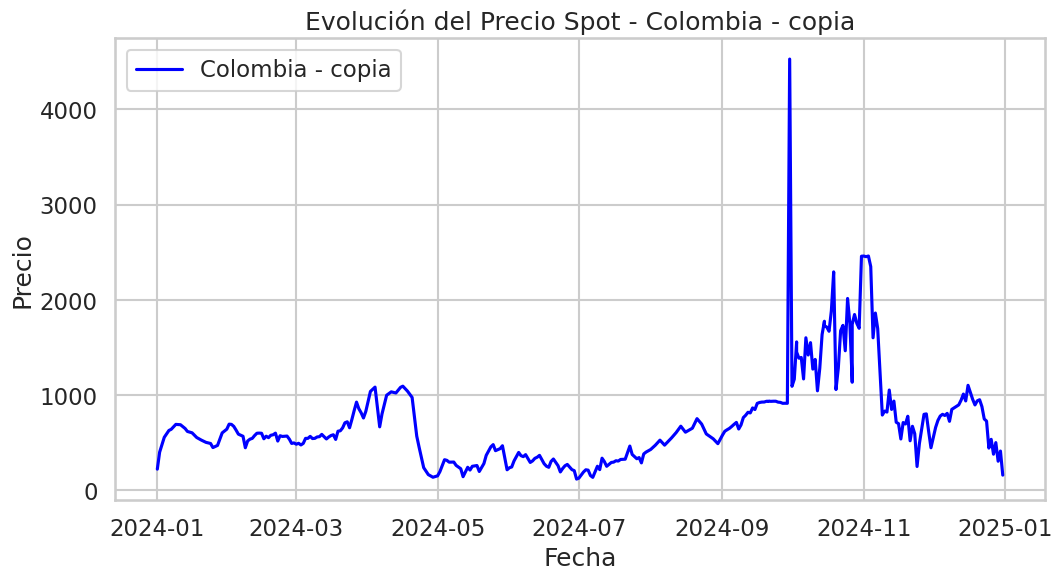

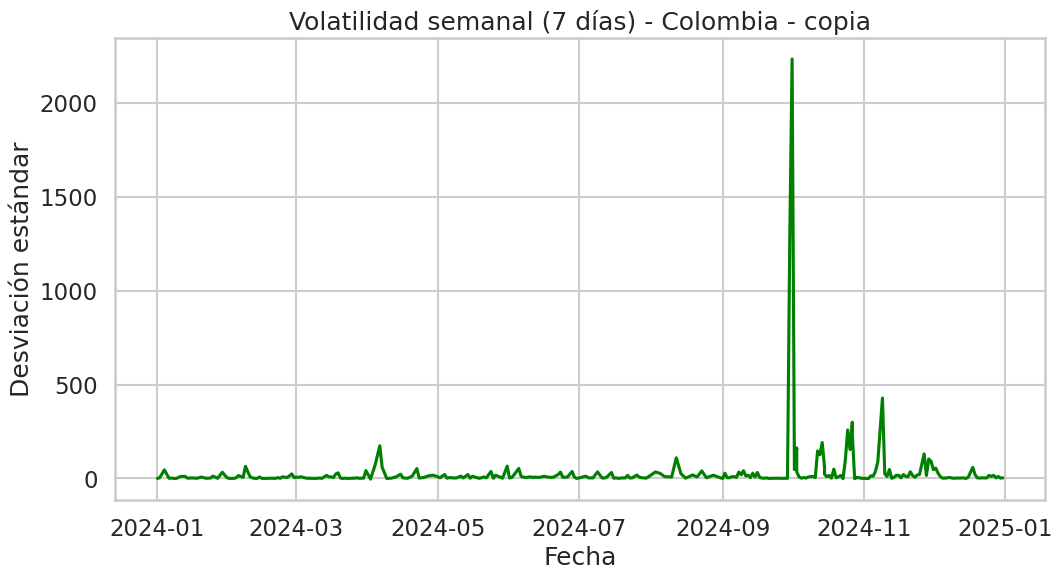

In [141]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Gráfica 1: Evolución del precio spot (suavizada)
df_col = df_col.sort_values("Fecha").dropna(subset=["Valor"]).reset_index(drop=True)
x = np.arange(len(df_col))
y = df_col["Valor"].values
x_new = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_new)

plt.plot(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 300).astype(int)], y_smooth, label=pais_nombre, color="blue")
plt.title(f"Evolución del Precio Spot - {pais_nombre}")
plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.legend(); plt.grid(True); plt.show()

# Gráfica 2: Volatilidad semanal (suavizada)
df_col["Volatilidad_7d"] = df_col["Valor"].rolling(7, min_periods=1).std().fillna(0) # Added .fillna(0)
x = np.arange(len(df_col))
y = df_col["Volatilidad_7d"].values
x_new = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_new)

plt.plot(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 300).astype(int)], y_smooth, color="green")
plt.title(f"Volatilidad semanal (7 días) - {pais_nombre}")
plt.xlabel("Fecha"); plt.ylabel("Desviación estándar"); plt.grid(True); plt.show()

# Gráficas 3: Precio vs variables externas (con curvas suavizadas)
for v in ["Embalses", "Combustibles", "Precipitaciones"]:
    if df_col[v].notna().sum() > 5:
        x = df_col[v].values
        y = df_col["Valor"].values
        idx = np.argsort(x)
        x_sorted, y_sorted = x[idx], y[idx]
        spl = make_interp_spline(x_sorted, y_sorted, k=3)
        x_new = np.linspace(x_sorted.min(), x_sorted.max(), 300)
        y_smooth = spl(x_new)
        sns.scatterplot(x=x, y=y, alpha=0.4)
        plt.plot(x_new, y_smooth, color="red")
        plt.title(f"{pais_nombre}: Precio vs {v}")
        plt.xlabel(v); plt.ylabel("Precio"); plt.grid(True); plt.show()

**Análisis y visualización de tendencias del mercado eléctrico colombiano**: En esta sección se realiza la visualización y análisis de las principales variables del mercado eléctrico colombiano a través de técnicas de interpolación y suavización de datos.
Primero, se representa la evolución temporal del precio spot, mostrando su comportamiento general y las fluctuaciones diarias. Luego, se calcula y grafica la volatilidad semanal, que mide la variación del precio en periodos de siete días. Finalmente, se exploran las relaciones entre el precio y variables externas como los niveles de embalses, el costo de los combustibles y las precipitaciones, utilizando curvas suavizadas para identificar tendencias y posibles correlaciones entre estos factores.

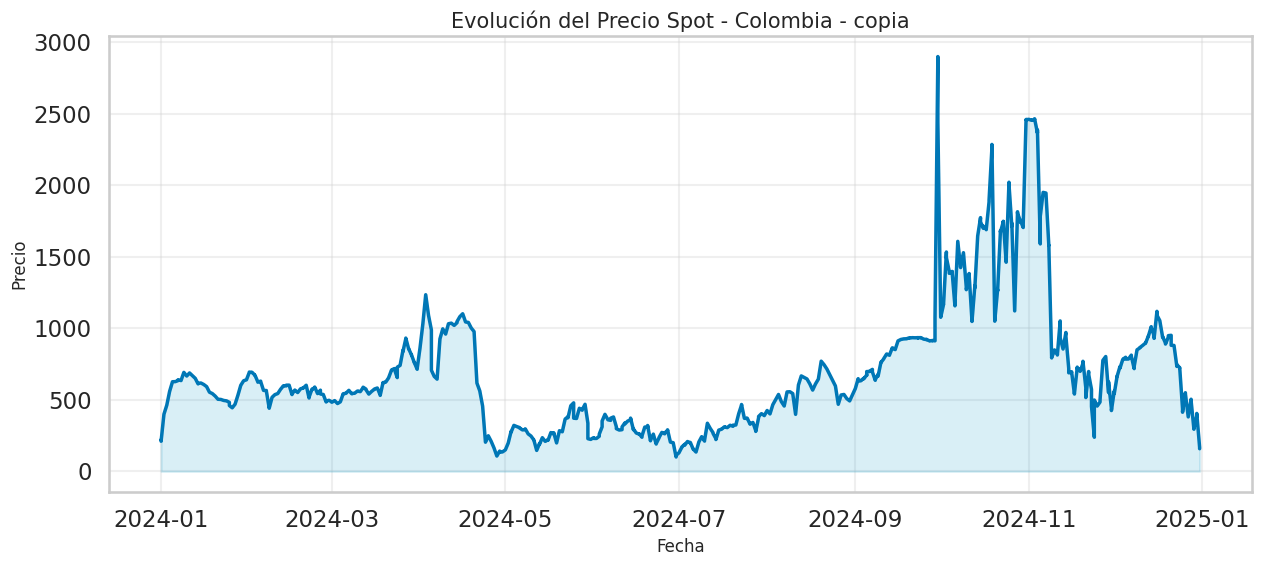

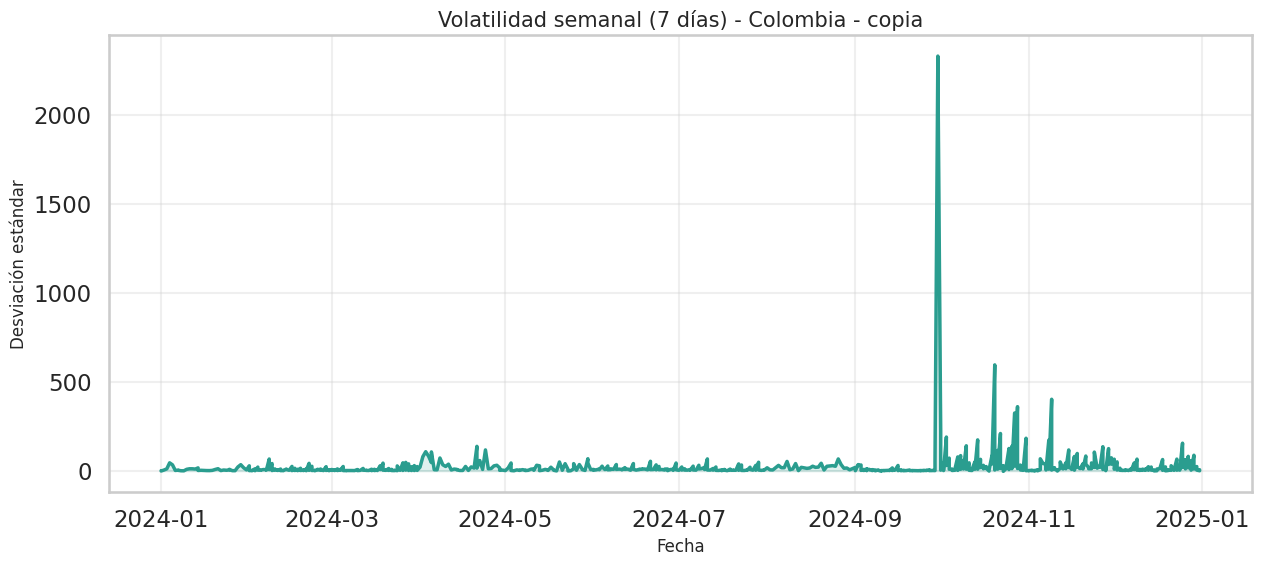

In [142]:
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (13, 6)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.labelsize"] = 12

df_col = df_col.sort_values("Fecha").dropna(subset=["Valor"]).reset_index(drop=True)

# Gráfica 1: Evolución del precio spot (suavizada)
x = np.arange(len(df_col))
y = df_col["Valor"].values
x_new = np.linspace(x.min(), x.max(), 600)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_new)

plt.figure()
plt.plot(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 600).astype(int)], y_smooth, color="#0077b6", linewidth=2.5)
plt.fill_between(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 600).astype(int)], y_smooth, alpha=0.15, color="#0096c7")
plt.title(f"Evolución del Precio Spot - {pais_nombre}")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 2: Volatilidad semanal (suavizada)
df_col["Volatilidad_7d"] = df_col["Valor"].rolling(7, min_periods=1).std().fillna(0)
x = np.arange(len(df_col))
y = df_col["Volatilidad_7d"].values
x_new = np.linspace(x.min(), x.max(), 600)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_new)

plt.figure()
plt.plot(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 600).astype(int)], y_smooth, color="#2a9d8f", linewidth=2.5)
plt.fill_between(df_col["Fecha"].iloc[np.linspace(0, len(df_col)-1, 600).astype(int)], y_smooth, alpha=0.15, color="#2a9d8f")
plt.title(f"Volatilidad semanal (7 días) - {pais_nombre}")
plt.xlabel("Fecha")
plt.ylabel("Desviación estándar")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Gráficas 3: Precio vs variables externas (con curvas suavizadas)
for v in ["Embalses", "Combustibles", "Precipitaciones"]:
    if df_col[v].notna().sum() > 5:
        x = df_col[v].values
        y = df_col["Valor"].values
        idx = np.argsort(x)
        x_sorted, y_sorted = x[idx], y[idx]
        spl = make_interp_spline(x_sorted, y_sorted, k=3)
        x_new = np.linspace(x_sorted.min(), x_sorted.max(), 600)
        y_smooth = spl(x_new)
        plt.figure()
        sns.scatterplot(x=x, y=y, alpha=0.3, color="#90e0ef", edgecolor=None)
        plt.plot(x_new, y_smooth, color="#d62828", linewidth=2.5)
        plt.title(f"{pais_nombre}: Precio vs {v}")
        plt.xlabel(v)
        plt.ylabel("Precio")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

In [143]:
df_col.to_csv(f"/content/{pais_nombre}_procesado.csv", index=False)
df_global.to_csv("/content/Precios_Globales.csv", index=False)
zip_path = "/content/datos_proyecto_precios.zip"
with zipfile.ZipFile(zip_path, "w") as z:
    z.write(f"/content/{pais_nombre}_procesado.csv", arcname=f"{pais_nombre}_procesado.csv")
    z.write("/content/Precios_Globales.csv", arcname="Precios_Globales.csv")
print("Archivos generados:")
print(f"/content/{pais_nombre}_procesado.csv")
print("/content/Precios_Globales.csv")
print("/content/datos_proyecto_precios.zip")

if 'uploaded' in locals() and uploaded:
    print("Archivos subidos:")
    for filename in uploaded.keys():
        print(f"- {filename}")

else:
    print(" No se encontró ningún archivo subido. Por favor, sube un archivo CSV primero.")

Archivos generados:
/content/Colombia - copia_procesado.csv
/content/Precios_Globales.csv
/content/datos_proyecto_precios.zip
Archivos subidos:
- Colombia - copia.csv


**Comparación internacional del precio spot de energía**: En esta parte del código se realiza la comparación internacional de los precios spot de la energía eléctrica entre distintos países.
El programa permite subir archivos con datos de precios históricos en diferentes monedas, detecta automáticamente las columnas relevantes y convierte los valores a dólares estadounidenses (USD) utilizando tasas de cambio definidas.
Posteriormente, se genera una gráfica temporal que muestra la evolución del precio spot por país y una gráfica de barras que presenta el promedio de precios para cada mercado.
Con esto, se facilita el análisis comparativo de costos energéticos, identificando diferencias en niveles y volatilidad entre los países estudiados.

Saving eeuu_precios_mensual.csv to eeuu_precios_mensual (27).csv
Saving mexico_precios_mensual.csv to mexico_precios_mensual (26).csv


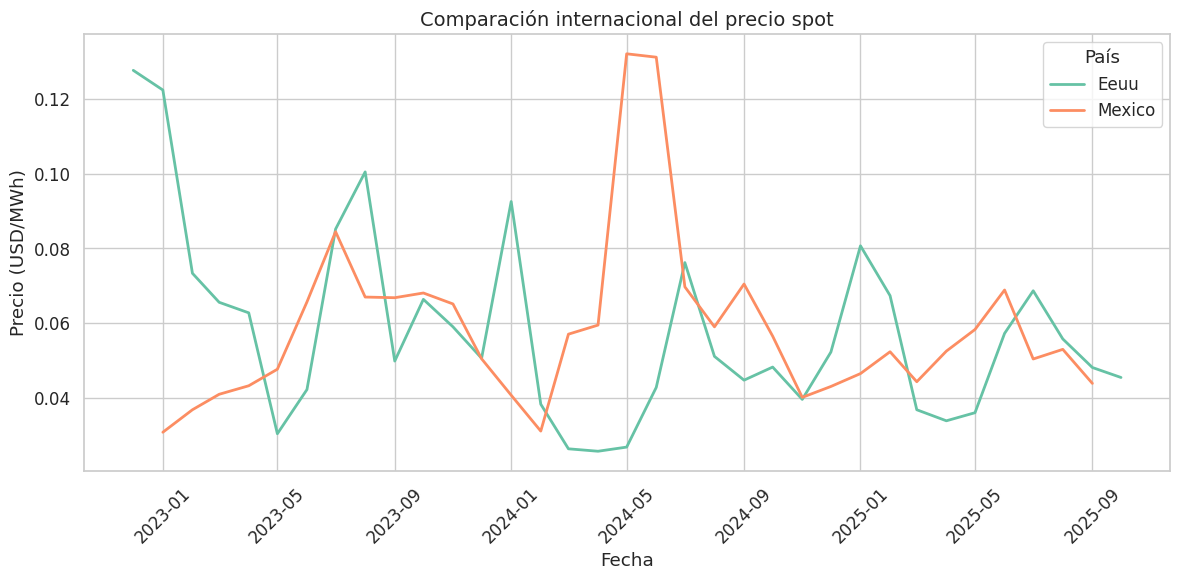

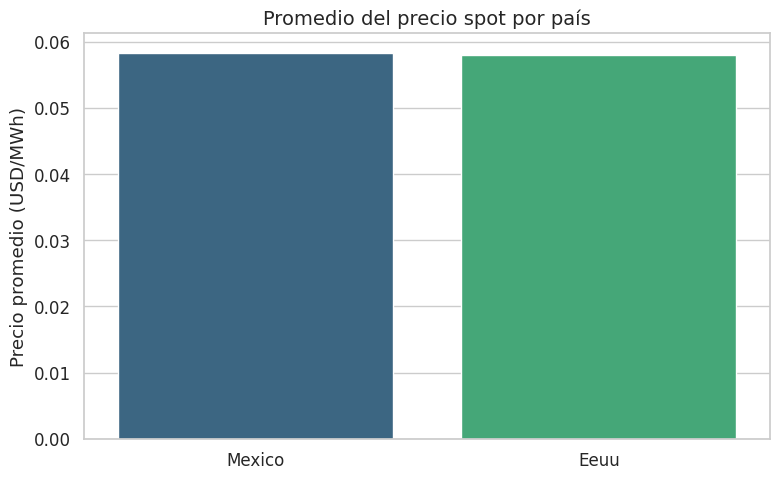

Promedio de precios por país (USD/MWh):
Mexico: 0.06
Eeuu: 0.06


In [144]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np

sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

uploaded = files.upload()

tasas = {
    "COP": 0.00025,
    "BRL": 0.19,
    "EUR": 1.08,
    "AUD": 0.64,
    "USD": 1.00
}

precios = pd.DataFrame()

for nombre_archivo, contenido in uploaded.items():
    try:
        df = pd.read_csv(io.BytesIO(contenido))
        df.columns = [c.strip().replace("\ufeff","") for c in df.columns] # Clean column names

        pais = nombre_archivo.split('.')[0].split('_')[0].capitalize()

        # Robust column detection for fecha_col
        fecha_col_candidates = [c for c in df.columns if 'fecha' in c.lower() or 'date' in c.lower()]
        if not fecha_col_candidates and 'anio_mes' in df.columns:
            fecha_col_candidates = ['anio_mes']
        if not fecha_col_candidates:
            print(f"Error: No se encontró una columna de fecha en '{nombre_archivo}'. Se saltará este archivo.")
            continue
        fecha_col_name = fecha_col_candidates[0]

        # Robust column detection for precio_col
        precio_col_candidates = [c for c in df.columns if 'valor' in c.lower() or 'price' in c.lower() or 'rrp' in c.lower()]
        if not precio_col_candidates and 'precio_promedio_cop_kwh' in df.columns:
            precio_col_candidates = ['precio_promedio_cop_kwh']
        if not precio_col_candidates:
            print(f"Error: No se encontró una columna de precio en '{nombre_archivo}'. Se saltará este archivo.")
            continue
        precio_col_name = precio_col_candidates[0]

        df['Fecha'] = pd.to_datetime(df[fecha_col_name], errors='coerce')
        df['Precio'] = df[precio_col_name].astype(float)

        # Determine currency and convert to USD
        moneda_detectada = next((m for m in tasas.keys() if m.lower() in precio_col_name.lower()), "USD")
        df['Precio_USD'] = df['Precio'] * tasas[moneda_detectada]

        df['País'] = pais
        precios = pd.concat([precios, df[['Fecha', 'País', 'Precio_USD']]], ignore_index=True)
    except Exception as e:
        print(f"Error procesando {nombre_archivo}: {e}")

precios = precios.dropna(subset=['Fecha', 'Precio_USD'])
precios = precios.sort_values(by='Fecha')

plt.figure(figsize=(12,6))
sns.lineplot(data=precios, x='Fecha', y='Precio_USD', hue='País', linewidth=2)
plt.title("Comparación internacional del precio spot", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio (USD/MWh)")
plt.xticks(rotation=45)
plt.legend(title="País")
plt.tight_layout()
plt.show()

promedios = precios.groupby('País')['Precio_USD'].mean().reset_index().sort_values(by='Precio_USD', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=promedios, x='País', y='Precio_USD', hue='País', palette="viridis", legend=False, order=promedios['País'])
plt.title("Promedio del precio spot por país", fontsize=14)
plt.ylabel("Precio promedio (USD/MWh)")
plt.xlabel("")
plt.tight_layout()
plt.show()

print("Promedio de precios por país (USD/MWh):")
for _, row in promedios.iterrows():
    print(f"{row['País']}: {row['Precio_USD']:.2f}")

**Interpolación y visualización de precios energéticos por país:** En esta sección se realiza la lectura, limpieza e interpolación de series de precios de energía provenientes de distintos países.

Saving eeuu_precios_mensual.csv to eeuu_precios_mensual (28).csv
Saving mexico_precios_mensual.csv to mexico_precios_mensual (27).csv


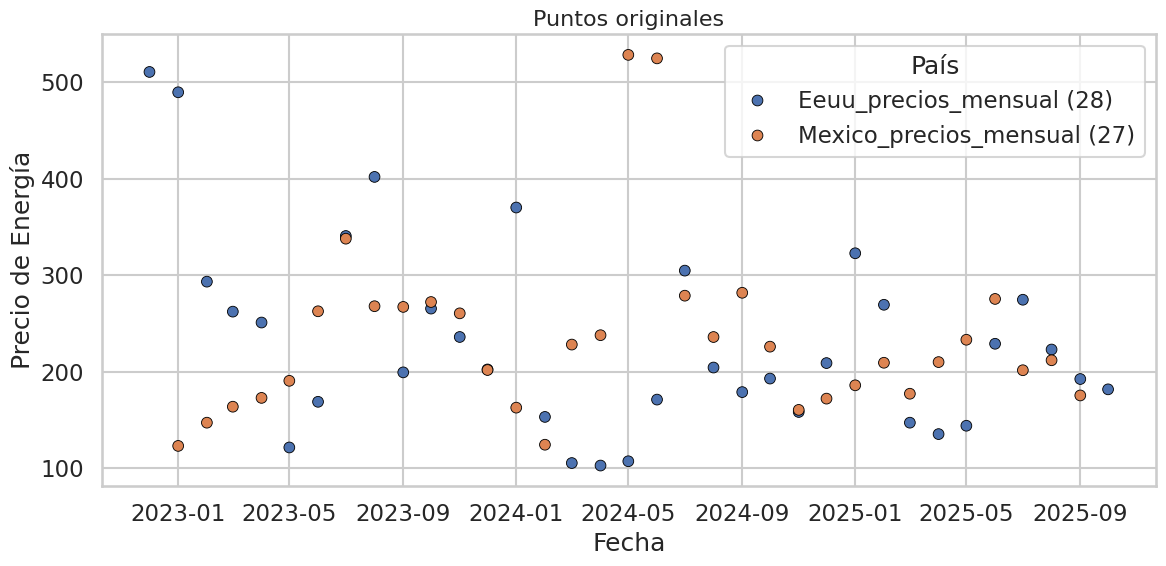

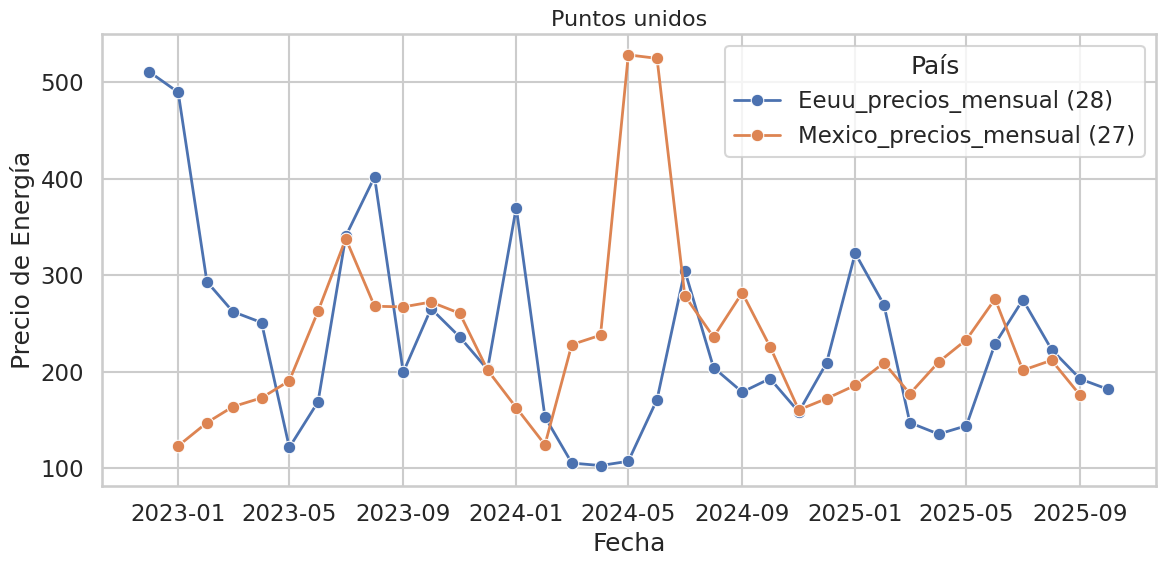

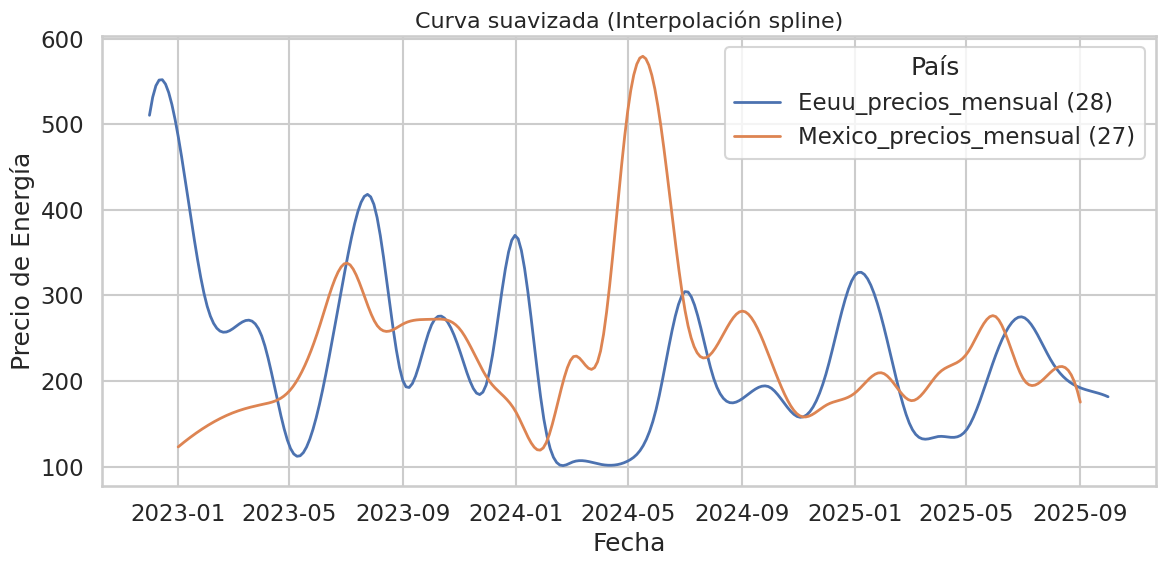

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.interpolate import make_interp_spline
import io

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12,6)

uploaded = files.upload()
puntos = []
lineas = []
suavizado = []

for nombre, contenido in uploaded.items():
    df = pd.read_csv(io.BytesIO(contenido))
    pais = nombre.split('.')[0].capitalize()
    df.columns = [c.strip().replace("\ufeff", "") for c in df.columns]

    fecha_col = None
    for c in ["Fecha", "fecha", "Date", "FECHA", "anio_mes"]:
        if c in df.columns:
            fecha_col = c
            break
    if fecha_col is None:
        continue
    df.rename(columns={fecha_col: "Fecha"}, inplace=True)

    valor_col = None
    for c in ["Valor", "valor", "Precio", "precio", "Price", "PPBO", "precio_promedio_cop_kwh"]:
        if c in df.columns:
            valor_col = c
            break
    if valor_col is None:
        continue
    df.rename(columns={valor_col: "Valor"}, inplace=True)

    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.dropna(subset=["Fecha", "Valor"]).sort_values("Fecha")

    if len(df) > 4:
        x = np.arange(len(df))
        y = df["Valor"].values
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_smooth)
        fechas_smooth = pd.to_datetime(np.linspace(df["Fecha"].iloc[0].value, df["Fecha"].iloc[-1].value, 300))
        df_interp = pd.DataFrame({"Fecha": fechas_smooth, "Valor": y_smooth, "País": pais})
        puntos.append(df.assign(País=pais))
        lineas.append(df.assign(País=pais))
        suavizado.append(df_interp)

if puntos:
    df_puntos = pd.concat(puntos, ignore_index=True)
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df_puntos, x="Fecha", y="Valor", hue="País", s=60, marker="o", edgecolor="black")
    plt.title("Puntos originales", fontsize=16)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Energía")
    plt.tight_layout()
    plt.show()

if lineas:
    df_lineas = pd.concat(lineas, ignore_index=True)
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_lineas, x="Fecha", y="Valor", hue="País", linewidth=2, marker="o")
    plt.title("Puntos unidos", fontsize=16)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Energía")
    plt.tight_layout()
    plt.show()

if suavizado:
    df_suave = pd.concat(suavizado, ignore_index=True)
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_suave, x="Fecha", y="Valor", hue="País", linewidth=2)
    plt.title("Curva suavizada (Interpolación spline)", fontsize=16)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Energía")
    plt.tight_layout()
    plt.show()
else:
    print("No se pudieron procesar datos para generar las gráficas.")



Saving eeuu_precios_mensual.csv to eeuu_precios_mensual (29).csv
Saving mexico_precios_mensual.csv to mexico_precios_mensual (28).csv


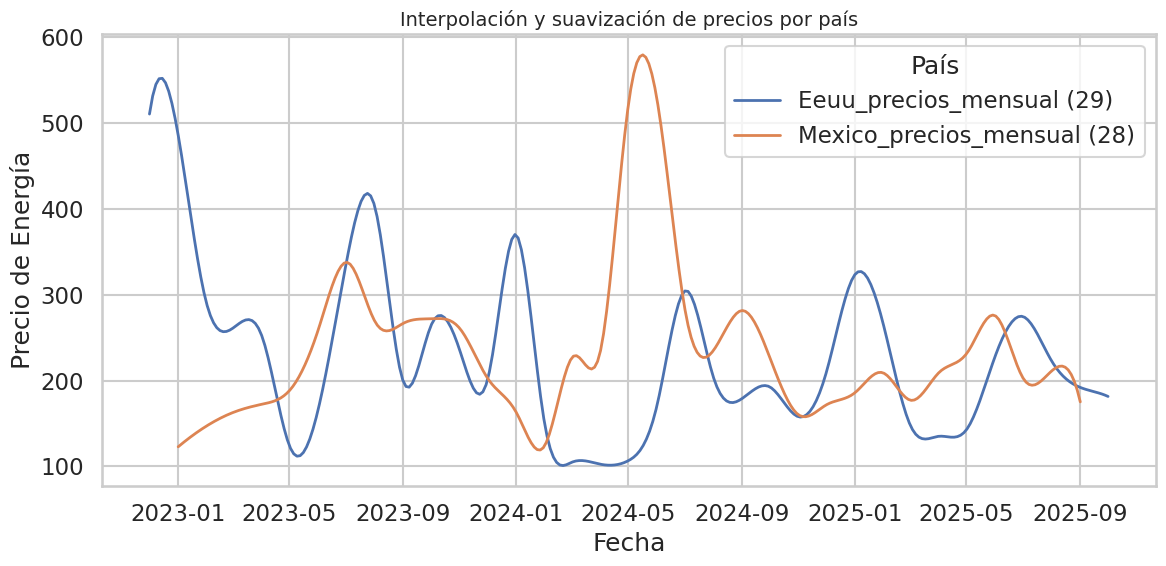

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.interpolate import make_interp_spline
import io # Import io for BytesIO

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12,6)

uploaded = files.upload()
precios = []

for nombre, contenido in uploaded.items():
    df = pd.read_csv(io.BytesIO(contenido))
    pais = nombre.split('.')[0].capitalize()

    # Clean column names first to ensure consistent matching
    df.columns = [c.strip().replace("\ufeff","") for c in df.columns]

    # Robust detection for 'Fecha' column
    fecha_col_found = False
    if "Fecha" in df.columns:
        fecha_col_found = True
    else:
        for c in ["fecha", "Date", "FECHA", "anio_mes"]:
            if c in df.columns:
                df.rename(columns={c: "Fecha"}, inplace=True);
                fecha_col_found = True
                break
    if not fecha_col_found:
        print(f"Advertencia: No se encontró una columna de fecha en {nombre}. Se saltará este archivo.")
        continue

    # Robust detection for 'Valor' column
    valor_col_found = False
    if "Valor" in df.columns:
        valor_col_found = True
    else:
        for c in ["Precio", "precio", "Price (USD/MWh)", "Price", "PPBO", "precio_promedio_cop_kwh"]:
            if c in df.columns:
                df.rename(columns={c: "Valor"}, inplace=True);
                valor_col_found = True
                break
    if not valor_col_found:
        print(f"Advertencia: No se encontró una columna de valor en {nombre}. Se saltará este archivo.")
        continue

    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.dropna(subset=["Fecha", "Valor"]).sort_values("Fecha")
    if len(df) > 4:
        x = np.arange(len(df))
        y = df["Valor"].values
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_smooth)
        fechas_smooth = np.linspace(df["Fecha"].iloc[0].value, df["Fecha"].iloc[-1].value, 300)
        df_interp = pd.DataFrame({"Fecha": pd.to_datetime(fechas_smooth), "Valor": y_smooth, "País": pais})
        precios.append(df_interp)

if precios:
    df_total = pd.concat(precios, ignore_index=True)
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_total, x="Fecha", y="Valor", hue="País", linewidth=2)
    plt.title("Interpolación y suavización de precios por país", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Precio de Energía")
    plt.tight_layout()
    plt.show()
else:
    print("No se pudieron procesar datos de ningún archivo para generar la gráfica.")

**Generación y visualización de datos simulados del precio spot**: En esta sección se emplea la función generar_datos_pais() para crear un conjunto de datos simulados que representan la evolución del precio spot de energía en un país determinado.
La función genera valores diarios para el precio a partir de una base inicial, incorporando variaciones aleatorias que imitan el comportamiento real del mercado eléctrico.

Datos generados. Primeras filas:


,Fecha,Valor,Embalses,Combustibles,Precipitaciones,País
0,2024-01-01,295.969775,80.693332,70.337117,6.028583,.
1,2024-01-02,290.995042,81.118795,69.395781,0.837717,.
2,2024-01-03,282.722737,81.407632,70.269195,3.630034,.
3,2024-01-04,295.570934,81.917789,70.074813,14.203743,.
4,2024-01-05,280.583657,81.948498,70.530278,13.104297,.


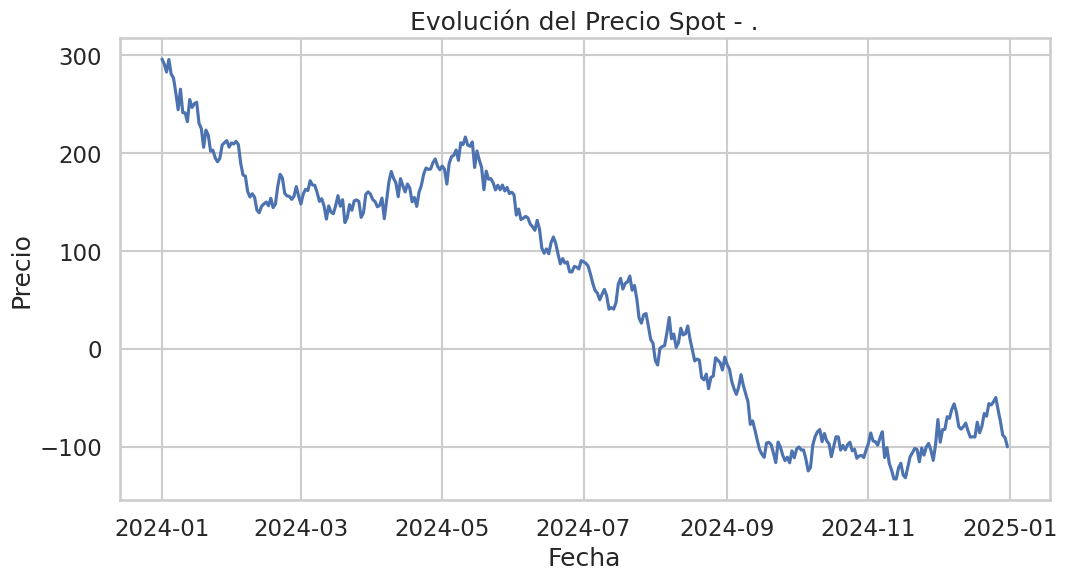


 Gráfica generada con datos.


In [147]:
pais_nombre_generado = "."
df_generado = generar_datos_pais(pais_nombre_generado, 300)

print("Datos generados. Primeras filas:")
display(df_generado.head())

plt.figure(figsize=(12, 6))
plt.plot(df_generado["Fecha"], df_generado["Valor"])
plt.title(f"Evolución del Precio Spot - {pais_nombre_generado}")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.grid(True)
plt.show()

print("\n Gráfica generada con datos.")

In [148]:
df_model = df_col.copy()

df_model['Dia_Semana'] = df_model['Fecha'].dt.dayofweek
df_model['Mes'] = df_model['Fecha'].dt.month
df_model['Año'] = df_model['Fecha'].dt.year

for col in ['Embalses', 'Combustibles', 'Precipitaciones']:
    if df_model[col].isnull().any():
        df_model[col] = df_model[col].interpolate(method='linear', limit_direction='both')
        if df_model[col].isnull().all():
            df_model[col] = df_model[col].fillna(0)
        else:
            df_model[col] = df_model[col].fillna(df_model[col].mean())

df_model.dropna(subset=['Valor'], inplace=True)

display(df_model.head())

,CodigoVariable,Fecha,CodigoDuracion,UnidadMedida,Version,Valor,Embalses,Combustibles,Precipitaciones,Volatilidad_7d,Dia_Semana,Mes,Año
0,PPBO,2024-01-01,P1D,COP/kWh,TXF,220.86,0.0,0.0,0.0,0.000000,0,1,2024
1,PPBOGReal,2024-01-01,P1D,COP/kWh,TXF,225.62,0.0,0.0,0.0,3.365828,0,1,2024
2,PPBO,2024-01-01,P1D,COP/kWh,TX4,221.09,0.0,0.0,0.0,2.684257,0,1,2024
3,PPBOGReal,2024-01-01,P1D,COP/kWh,TX4,225.87,0.0,0.0,0.0,2.757451,0,1,2024
4,PPBO,2024-01-01,P1D,COP/kWh,TX2,219.08,0.0,0.0,0.0,3.060446,0,1,2024


**Preparación y normalización de variables para el modelo predictivo**: realiza la selección y normalización de las variables independientes que alimentan el modelo de predicción del precio de la energía.

In [149]:
features = ['Volatilidad_7d', 'Embalses', 'Combustibles', 'Precipitaciones', 'Dia_Semana', 'Mes', 'Año']

if 'Volatilidad_7d' not in df_model.columns:
    df_model['Volatilidad_7d'] = df_model['Valor'].rolling(7, min_periods=1).std().fillna(0)

for f in features:
    if f not in df_model.columns:
        print(f"Advertencia: La característica '{f}' no se encuentra en df_model. Se rellenará con 0.")
        df_model[f] = 0

X = df_model[features]
y = df_model['Valor']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

display(pd.DataFrame(X_scaled, columns=features).head())

,Volatilidad_7d,Embalses,Combustibles,Precipitaciones,Dia_Semana,Mes,Año
0,-0.195028,0.0,0.0,0.0,-1.492274,-1.67578,0.0
1,-0.172909,0.0,0.0,0.0,-1.492274,-1.67578,0.0
2,-0.177388,0.0,0.0,0.0,-1.492274,-1.67578,0.0
3,-0.176907,0.0,0.0,0.0,-1.492274,-1.67578,0.0
4,-0.174916,0.0,0.0,0.0,-1.492274,-1.67578,0.0


In [150]:
from sklearn.model_selection import train_test_split

split = int(len(df_model) * 0.8)

X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} muestras")
print(f"Tamaño del conjunto de prueba: {len(X_test)} muestras")

Tamaño del conjunto de entrenamiento: 3759 muestras
Tamaño del conjunto de prueba: 940 muestras


**Predicción de precios mediante modelo polinomial**: esta sección se implementa un modelo de regresión polinomial de grado 3 para estimar la tendencia futura del precio de la energía eléctrica.
Primero, se convierten las fechas en una variable numérica secuencial que permite representar el paso del tiempo. Luego, se ajusta un modelo de regresión lineal polinómica, capaz de capturar patrones no lineales en la serie histórica de precios.

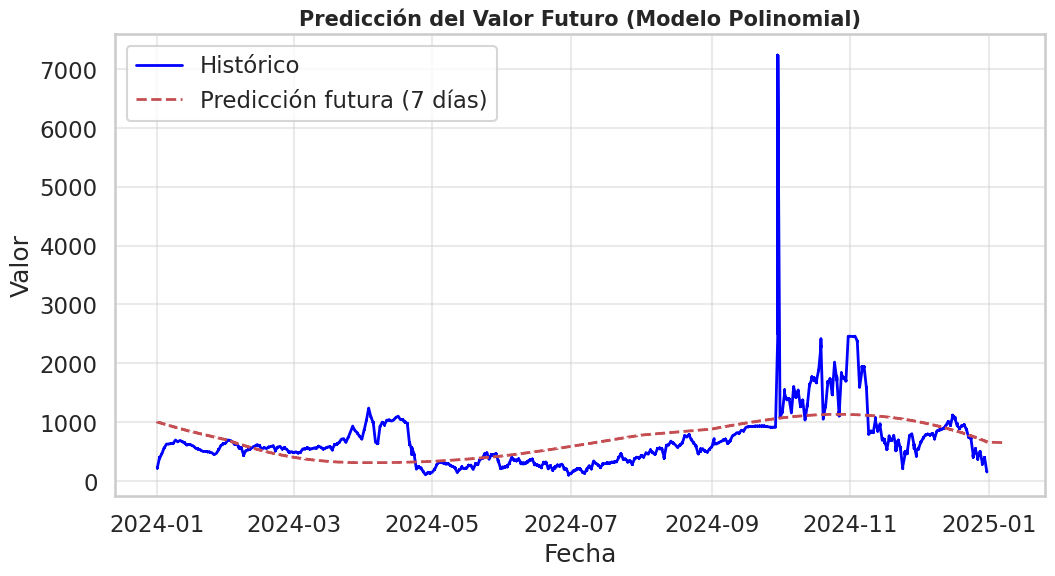

Día futuro 1: 658.31
Día futuro 2: 657.25
Día futuro 3: 656.19
Día futuro 4: 655.13
Día futuro 5: 654.06
Día futuro 6: 653.00
Día futuro 7: 651.94


In [151]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

datos = df_model.copy().dropna(subset=["Valor"])
datos = datos.sort_values("Fecha").reset_index(drop=True)
datos["Fecha_num"] = np.arange(len(datos))
X = datos[["Fecha_num"]]
y = datos["Valor"]

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
modelo_poly = LinearRegression()
modelo_poly.fit(X_poly, y)

dias_futuros = np.arange(len(datos), len(datos) + 7).reshape(-1, 1)
X_total = np.concatenate([X, dias_futuros])
pred_total = modelo_poly.predict(poly.transform(X_total))

fechas_futuras = pd.date_range(start=datos["Fecha"].iloc[-1], periods=8, freq="D")[1:]

plt.figure(figsize=(12,6))
plt.plot(datos["Fecha"], y, color="blue", label="Histórico", linewidth=2)
plt.plot(pd.concat([datos["Fecha"], pd.Series(fechas_futuras)]), pred_total, "r--", label="Predicción futura (7 días)", linewidth=2)
plt.title("Predicción del Valor Futuro (Modelo Polinomial)", fontsize=15, weight="bold")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

pred_futuras = modelo_poly.predict(poly.transform(dias_futuros))
pred_df = pd.DataFrame({
    "Día futuro": range(1, 8),
    "Predicción Valor": pred_futuras
})
for index, row in pred_df.iterrows():
    print(f"Día futuro {int(row['Día futuro'])}: {row['Predicción Valor']:.2f}")

**Análisis de volatilidad y evaluación de predicciones:** Primero, se calcula la volatilidad móvil a 7 días, que mide la variación del precio de la energía en el corto plazo y permite identificar periodos de estabilidad o alta fluctuación. Los resultados se almacenan en una tabla y se exportan a un archivo CSV.
Posteriormente, se construye una tabla comparativa entre los valores reales y los valores predichos por el modelo, junto con el error absoluto y el error porcentual de cada predicción. Esta información permite analizar la precisión del modelo y detectar posibles desviaciones en sus estimaciones.

In [152]:
import numpy as np
import pandas as pd

pais_nombre = "Colombia"

df_vol = df_col.copy()
df_vol["Volatilidad_7d"] = df_vol["Valor"].rolling(7, min_periods=1).std()
tabla_vol = df_vol[["Fecha", "Valor", "Volatilidad_7d"]].tail(15)
display(tabla_vol)
df_vol.to_csv(f"/content/{pais_nombre}_Volatilidad.csv", index=False)

tabla_pred = pd.DataFrame({
    "Fecha": df_model["Fecha"].iloc[split:].values,
    "Real": y_test.values,
    "Predicho": y_pred
})
tabla_pred["Error_Abs"] = np.abs(tabla_pred["Real"] - tabla_pred["Predicho"])
tabla_pred["Error_%"] = np.abs(tabla_pred["Error_Abs"] / tabla_pred["Real"]) * 100
display(tabla_pred.tail(15))
tabla_pred.to_csv(f"/content/{pais_nombre}_Predicciones.csv", index=False)

,Fecha,Valor,Volatilidad_7d
4684,2024-12-31,157.84,88.584163
4685,2024-12-31,162.58,112.166502
4686,2024-12-31,161.98,123.822701
4687,2024-12-31,152.65,126.208331
4688,2024-12-31,157.83,114.261868
4689,2024-12-31,168.29,90.364828
4690,2024-12-31,167.84,5.665191
4691,2024-12-31,167.84,5.906744
4692,2024-12-31,158.40,6.129827
4693,2024-12-31,158.39,6.291404


,Fecha,Real,Predicho,Error_Abs,Error_%
925,2024-12-31,157.84,1431.801500,1273.961500,807.122086
926,2024-12-31,162.58,1392.874400,1230.294400,756.731701
927,2024-12-31,161.98,1549.664400,1387.684400,856.701074
928,2024-12-31,152.65,1560.378500,1407.728500,922.193580
929,2024-12-31,157.83,1465.096100,1307.266100,828.274789
930,2024-12-31,168.29,1440.887000,1272.597000,756.192881
931,2024-12-31,167.84,1740.300382,1572.460382,936.880590
932,2024-12-31,167.84,1744.971590,1577.131590,939.663722
933,2024-12-31,158.40,1732.227133,1573.827133,993.577736
934,2024-12-31,158.39,1724.454627,1566.064627,988.739584


**Evaluación del modelo y comparación de variables externas:**

===== EVALUACIÓN DEL MODELO (Random Forest) =====
MAE  (Error Absoluto Medio): 763.882
RMSE (Raíz Error Cuadrático Medio): 844.951
R²   (Coeficiente de Determinación): -1.248


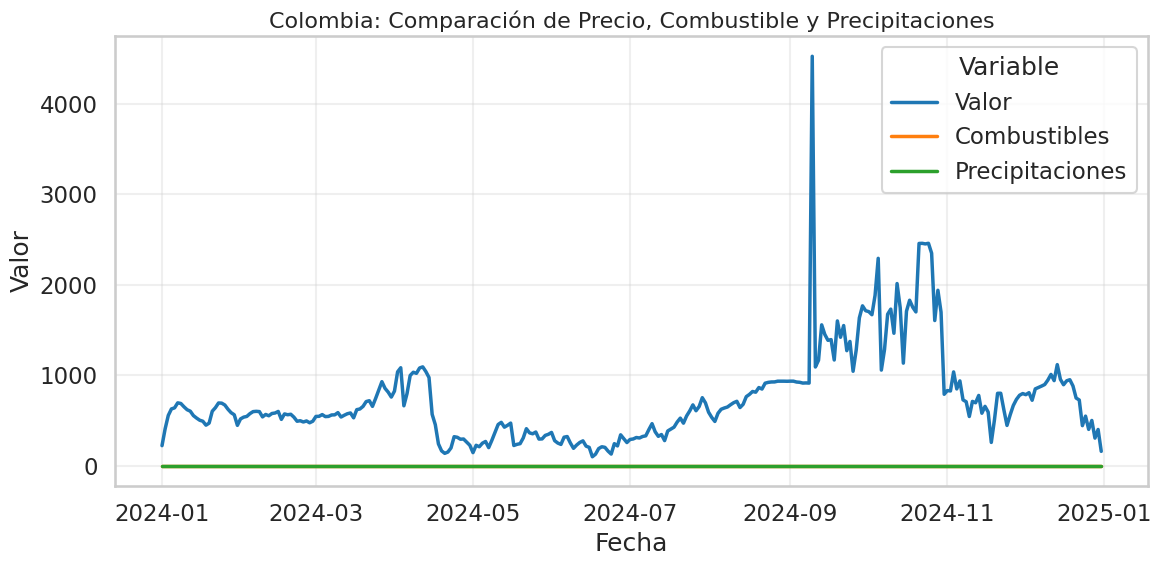

In [153]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("===== EVALUACIÓN DEL MODELO (Random Forest) =====")
print(f"MAE  (Error Absoluto Medio): {mae:.3f}")
print(f"RMSE (Raíz Error Cuadrático Medio): {rmse:.3f}")
print(f"R²   (Coeficiente de Determinación): {r2:.3f}")

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))

df_plot = df_model.dropna(subset=["Valor", "Combustibles", "Precipitaciones"]).sort_values("Fecha")

x = np.arange(len(df_plot))
fechas_smooth = pd.to_datetime(np.linspace(df_plot["Fecha"].iloc[0].value,
                                            df_plot["Fecha"].iloc[-1].value, 300))

for col, color in zip(["Valor", "Combustibles", "Precipitaciones"],
                      ["#1f77b4", "#ff7f0e", "#2ca02c"]):
    y = df_plot[col].values
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)
    plt.plot(fechas_smooth, y_smooth, label=col, linewidth=2.5, color=color)

plt.title(f"{pais_nombre}: Comparación de Precio, Combustible y Precipitaciones", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend(title="Variable")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Visualización de promedios y métricas de desempeño del modelo**

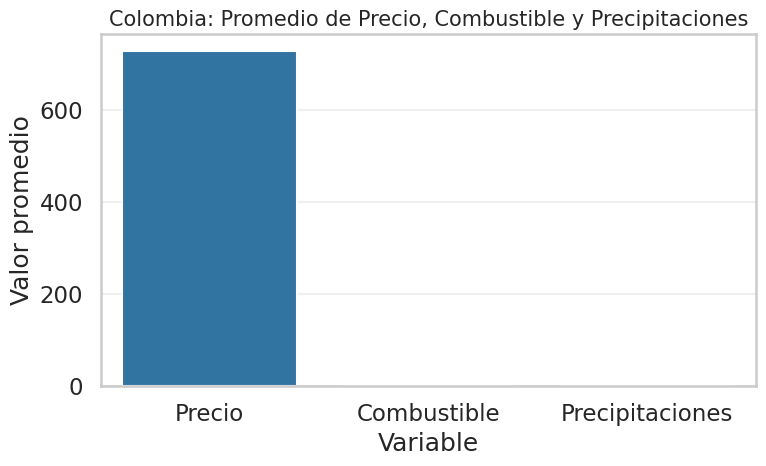

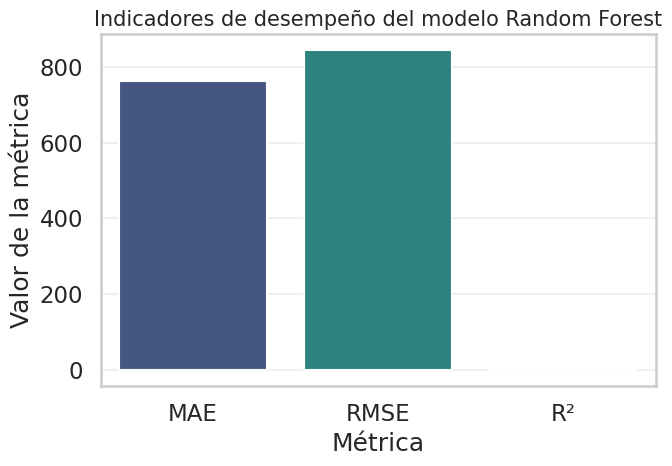

In [154]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

promedios = {
    "Precio": df_model["Valor"].mean(),
    "Combustible": df_model["Combustibles"].mean(),
    "Precipitaciones": df_model["Precipitaciones"].mean()
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(promedios.keys()), y=list(promedios.values()), palette=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title(f"{pais_nombre}: Promedio de Precio, Combustible y Precipitaciones", fontsize=15)
plt.ylabel("Valor promedio")
plt.xlabel("Variable")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

metricas = {
    "MAE": mae,
    "RMSE": rmse,
    "R²": r2
}

plt.figure(figsize=(7,5))
sns.barplot(x=list(metricas.keys()), y=list(metricas.values()), palette="viridis")
plt.title("Indicadores de desempeño del modelo Random Forest", fontsize=15)
plt.ylabel("Valor de la métrica")
plt.xlabel("Métrica")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
